# <font color="yellow"> Data Analysis Part 2

In [1]:
# Import necessary Libraries
import os
import pyproj
import warnings
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

In [3]:
# Read the trips dataframe
trips_df = pd.read_csv('od_trips.csv')

In [4]:
# Read the intersection shape file
# The intersection shape file is generated by ArcGIS Pro software
path = r'C:\Corrado\Intersection'
shape_file = 'intersection.shp'
data_path = os.path.join(path, shape_file)

In [5]:
# Read the shapefile into a GeoDataFrame
gdf = gpd.read_file(data_path)

In [6]:
# Head of the intersction shape file
gdf.head(3)

,FID_zurich,scenario,FID_NPVM20,row_id,ID_Zo,N_Zo,ID_Typ,ID_Kt,N_Kt,ID_A00_9,N_A00_9,ID_B00_9,N_B00_9,ID_B00_22,N_B00_22,ID_Agg00,N_Agg00,ID_Ms00,N_Ms00,ID_Rp00,N_Rp00,ID_Bez,N_Bez,ID_Greg00,N_Greg00,ZoneVZA,ZonePop,Shape_Leng,Shape_Area,geometry
0,0,zurich_city,0,1,1,Aeugst am Albis,1,1,ZH,3,Gürtel der Grosszentren,4,Periurbane Gemeinden (PERI),11,Periurbane Gemeinden metropolitaner Regionen (MP),261,Zürich,4,Knonaueramt,105,Knonaueramt,101,Bezirk Affoltern,4,Zürich,314.087029,1308,9821.387925,3.770566e+06,"POLYGON ((2680806.097 1237763.462, 2680946.457..."
1,0,zurich_city,1,2,2,Affoltern am Albis,1,1,ZH,2,Nebenzentren der Grosszentren,2,Suburbane Gemeinden (SUB),9,Arbeitsplatzgemeinden metropolitaner Regionen ...,261,Zürich,4,Knonaueramt,105,Knonaueramt,101,Bezirk Affoltern,4,Zürich,5186.270790,7766,7116.792418,1.514313e+06,"POLYGON ((2678522.756 1238539.672, 2678519.596..."
2,0,zurich_city,2,3,3,Bonstetten,1,1,ZH,3,Gürtel der Grosszentren,4,Periurbane Gemeinden (PERI),11,Periurbane Gemeinden metropolitaner Regionen (MP),261,Zürich,4,Knonaueramt,105,Knonaueramt,101,Bezirk Affoltern,4,Zürich,889.545489,3407,16043.086260,7.430706e+06,"POLYGON ((2679007.687 1241960.089, 2679014.799..."


In [9]:
trips_df.head(3)

,id,plan_id,origin,destination,x_o,y_o,x_d,y_d,trip_start_time,trip_end_time
0,1.0,1.0,home,outside,2.679482e+06,1.237545e+06,2.687165e+06,1.240056e+06,07:50:56,NaN
1,9.0,1.0,outside,outside,2.687165e+06,1.240056e+06,2.688163e+06,1.240087e+06,08:44:00,NaN
2,10.0,1.0,outside,home,2.688163e+06,1.240087e+06,2.679482e+06,1.237545e+06,08:59:00,08:35:56


In [12]:
# select the plan_id of the trips without outside in their origin and destination
plan_id_list = []
for plan_id, group in trips_df.groupby('plan_id'):
    if ('outside' not in group['origin'].values) and ('outside' not in group['destination'].values):
        plan_id_list.append(plan_id)

In [13]:
len(plan_id_list)

53362

In [14]:
# Dataframe which elminate all the trips when they have outside in their origin and destination
trips_df_without_outside = trips_df[trips_df['plan_id'].isin(plan_id_list)]

In [15]:
# Shape of the dataframe
trips_df_without_outside.shape

(204092, 10)

In [16]:
# Create a spatial index for gdf
gdf_sindex = gdf.sindex

# This function returns the zones of the origins and destinations 
def find_zone(data_row):
    origin = Point(data_row['x_o'], data_row['y_o'])
    destination = Point(data_row['x_d'], data_row['y_d'])

    # Use spatial index to find the containing zone
    possible_origin_matches = list(gdf_sindex.intersection(origin.bounds))
    possible_destination_matches = list(gdf_sindex.intersection(destination.bounds))

    origin_zone = "Outside_zone_origin"
    destination_zone = "Outside_zone_destination"

    # Find the exact match for origin
    for i in possible_origin_matches:
        if gdf.loc[i, 'geometry'].contains(origin):
            origin_zone = gdf.loc[i, 'ID_Zo']
            break

    # Find the exact match for destination
    for i in possible_destination_matches:
        if gdf.loc[i, 'geometry'].contains(destination):
            destination_zone = gdf.loc[i, 'ID_Zo']
            break

    return origin_zone, destination_zone

In [17]:
# Apply the function to your DataFrame and create separate lists
origin_zones_list, destination_zones_list = zip(*trips_df_without_outside.apply(find_zone, axis=1))

In [18]:
# Create origin zone column
trips_df_without_outside['origin_zone'] = origin_zones_list

# Create destination zone column
trips_df_without_outside['destination_zone'] = destination_zones_list

In [19]:
# This function check the origin and destination of the trip and if they are equal returns 'IN' and if they are not equal returns 'EX'
def get_trip_type(row):
    if row['origin_zone'] == row['destination_zone']:
        return 'IN'
    else:
        return 'EX'

In [20]:
trips_df_without_outside['trip_type'] = trips_df_without_outside.apply(get_trip_type, axis=1)

In [21]:
# Head of the trips_df_without_outside dataframe
trips_df_without_outside.head()

,id,plan_id,origin,destination,x_o,y_o,x_d,y_d,trip_start_time,trip_end_time,origin_zone,destination_zone,trip_type
58,150.0,15.0,home,work,2690503.0,1254816.0,2689466.0,1252675.0,08:30:27,08:45:27,52,200,EX
59,151.0,15.0,work,leisure,2689466.0,1252675.0,2687348.0,1251550.0,10:15:27,10:45:27,200,69,EX
60,152.0,15.0,leisure,other,2687348.0,1251550.0,2686160.0,1250732.0,12:00:27,12:15:27,69,26112,EX
61,153.0,15.0,other,leisure,2686160.0,1250732.0,2681982.0,1253176.0,12:16:27,12:25:27,26112,26111,EX
62,154.0,15.0,leisure,work,2681982.0,1253176.0,2689466.0,1252675.0,13:00:27,13:15:27,26111,200,EX


In [27]:
# Create OD_Zone Column for distribution graph
trips_df_without_outside['OD_Zone'] = trips_df_without_outside['origin_zone'] + '-' + trips_df_without_outside['destination_zone']

In [ ]:
# You can uncomment this cell to save the data in csv file to later analysis
# trips_df_without_outside.to_csv('trips_df_eliminate_plan_id_with_outside.csv', index=False)

In [ ]:
# Read the trips_df_eliminate_plan_id_with_outside csv data
# trips_df_without_outside = pd.read_csv('trips_df_eliminate_plan_id_with_outside.csv')

### <font color="orange"> Task 05: OD Distribution by Zone Part 1 (All the Plan id trips are eliminated from the dataframe where there are outside in their origin or destination)

In [28]:
# Value counts of OD_Zone trips
trips_df_without_outside['OD_Zone'].value_counts().head(10)

26111-26111    9311
26109-26109    6772
26107-26107    5419
26103-26103    4777
26102-26102    4324
26110-26110    4059
191-191        3788
26106-26106    3196
62-62          2826
26112-26112    2760
Name: OD_Zone, dtype: int64

In [29]:
# Select first 10 most frequent OD_Zone trips
temp_od = trips_df_without_outside['OD_Zone'].value_counts().index
od_trips_to_drop = temp_od[10:]
most_frequent_od_trips = trips_df_without_outside[~trips_df_without_outside['OD_Zone'].isin(od_trips_to_drop)]

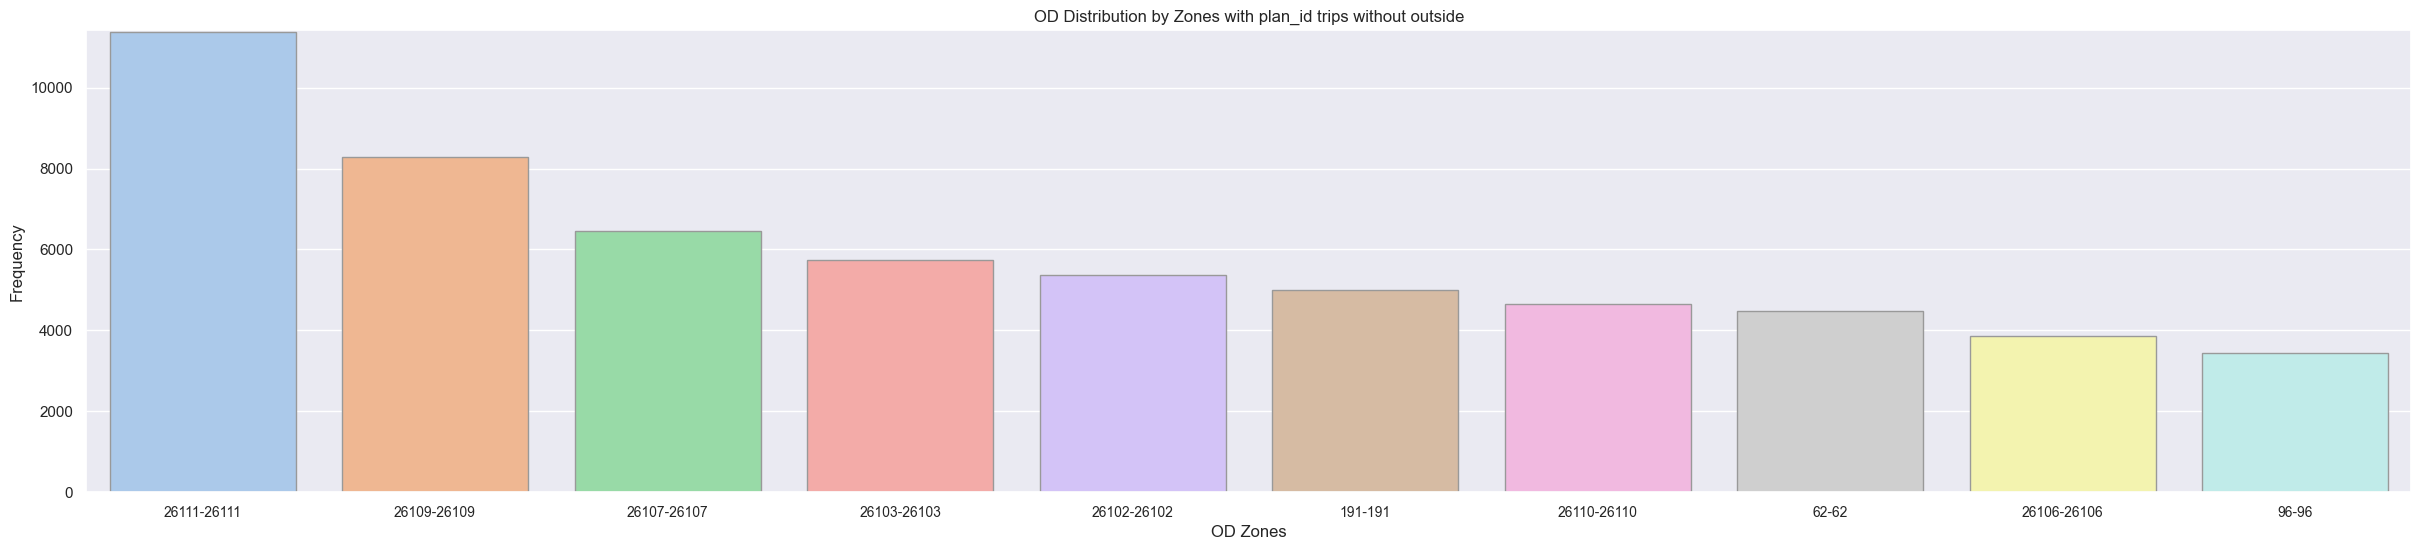

In [61]:
# Plot OD Distribution by zones of the trips_df_without_outside dataframe
# set sns style
sns.set(style="darkgrid")
plt.figure(figsize=(30, 6))

# Create a countplot for the 'OD_Zone' column 
value_counts = most_frequent_od_trips['OD_Zone'].value_counts().sort_values(ascending=False)
sns.countplot(data=most_frequent_od_trips, x="OD_Zone", order=value_counts.index, palette="pastel", edgecolor=".6")


# Add labels and a title to the plot
plt.xlabel("OD Zones")
plt.ylabel("Frequency")
plt.title("OD Distribution by Zones with plan_id trips without outside")

# Set the x-axis and y-axis 
max_frequency = most_frequent_od_trips['OD_Zone'].value_counts().iloc[0] + 50
plt.ylim(0, max_frequency) 
xticks_range = range(0, 10)
plt.xticks(xticks_range)
plt.yticks()
plt.xticks(fontsize=10)

# Show the plot
plt.show()

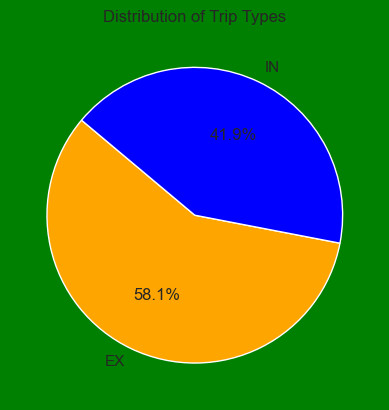

In [65]:
# Distribution of  EX and IN trips in trips_df_without_outside dataframe
trip_type_counts = trips_df_without_outside['trip_type'].value_counts()
# Create a figure and axes
fig, ax = plt.subplots()

# Set the colors of pie chart
colors = ['orange', 'blue']

# Set the background color of the plot
fig.set_facecolor('green') 

ax.pie(trip_type_counts, labels=trip_type_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Trip Types')

# Display the pie chart
plt.show()

### <font color="orange"> Task 05: OD Distribution by Zone Part 2 (All the Plan id trips are keeped but just the rows with outside in their origin or destination are dropped)

In [37]:
# All the rows dropped where there is 'outside' in origin or destination column 
trips_df_outside_dropped = trips_df[(trips_df['origin'] != 'outside') & (trips_df['destination'] != 'outside')]

In [38]:
# Shape of dropped dataframe
trips_df_outside_dropped.shape

(260660, 10)

In [39]:
# Apply the function to your DataFrame and create separate lists
origin_zones_list, destination_zones_list = zip(*trips_df_outside_dropped.apply(find_zone, axis=1))

In [53]:
# Create origin zone column
trips_df_outside_dropped['origin_zone'] = origin_zones_list

# Create destination zone column
trips_df_outside_dropped['destination_zone'] = destination_zones_list

In [54]:
# This function check the origin and destination of the trip and if they are equal returns 'IN' and if they are not equal returns 'EX'
def get_trip_type(row):
    if row['origin_zone'] == row['destination_zone']:
        return 'IN'
    else:
        return 'EX'

In [55]:
# Create trip type column with IN and EX values
trips_df_outside_dropped['trip_type'] = trips_df_outside_dropped.apply(get_trip_type, axis=1)

In [56]:
trips_df_outside_dropped['OD_Zone'] = trips_df_outside_dropped['origin_zone'] + '-' + trips_df_outside_dropped['destination_zone']

In [57]:
# Select first 10 most frequent OD_Zone trips
temp_od = trips_df_outside_dropped['OD_Zone'].value_counts().index
od_trips_to_drop = temp_od[10:]
most_frequent_od_trips = trips_df_outside_dropped[~trips_df_outside_dropped['OD_Zone'].isin(od_trips_to_drop)]

In [58]:
trips_df_outside_dropped.head()

,id,plan_id,origin,destination,x_o,y_o,x_d,y_d,trip_start_time,trip_end_time,origin_zone,destination_zone,trip_type,OD_Zone
3,17.0,1.0,home,leisure,2679482.0,1237545.0,2680684.0,1236911.0,11:05:56,11:15:56,1,1,IN,1-1
4,18.0,1.0,leisure,other,2680684.0,1236911.0,2680896.0,1238970.0,11:35:56,11:40:56,1,13,EX,1-13
5,19.0,1.0,other,leisure,2680896.0,1238970.0,2681830.0,1241204.0,11:50:56,11:55:56,13,131,EX,13-131
6,20.0,1.0,leisure,leisure,2681830.0,1241204.0,2681824.0,1241595.0,13:05:56,13:07:56,131,131,IN,131-131
7,21.0,1.0,leisure,other,2681824.0,1241595.0,2682414.0,1243360.0,13:45:56,13:50:56,131,26102,EX,131-26102


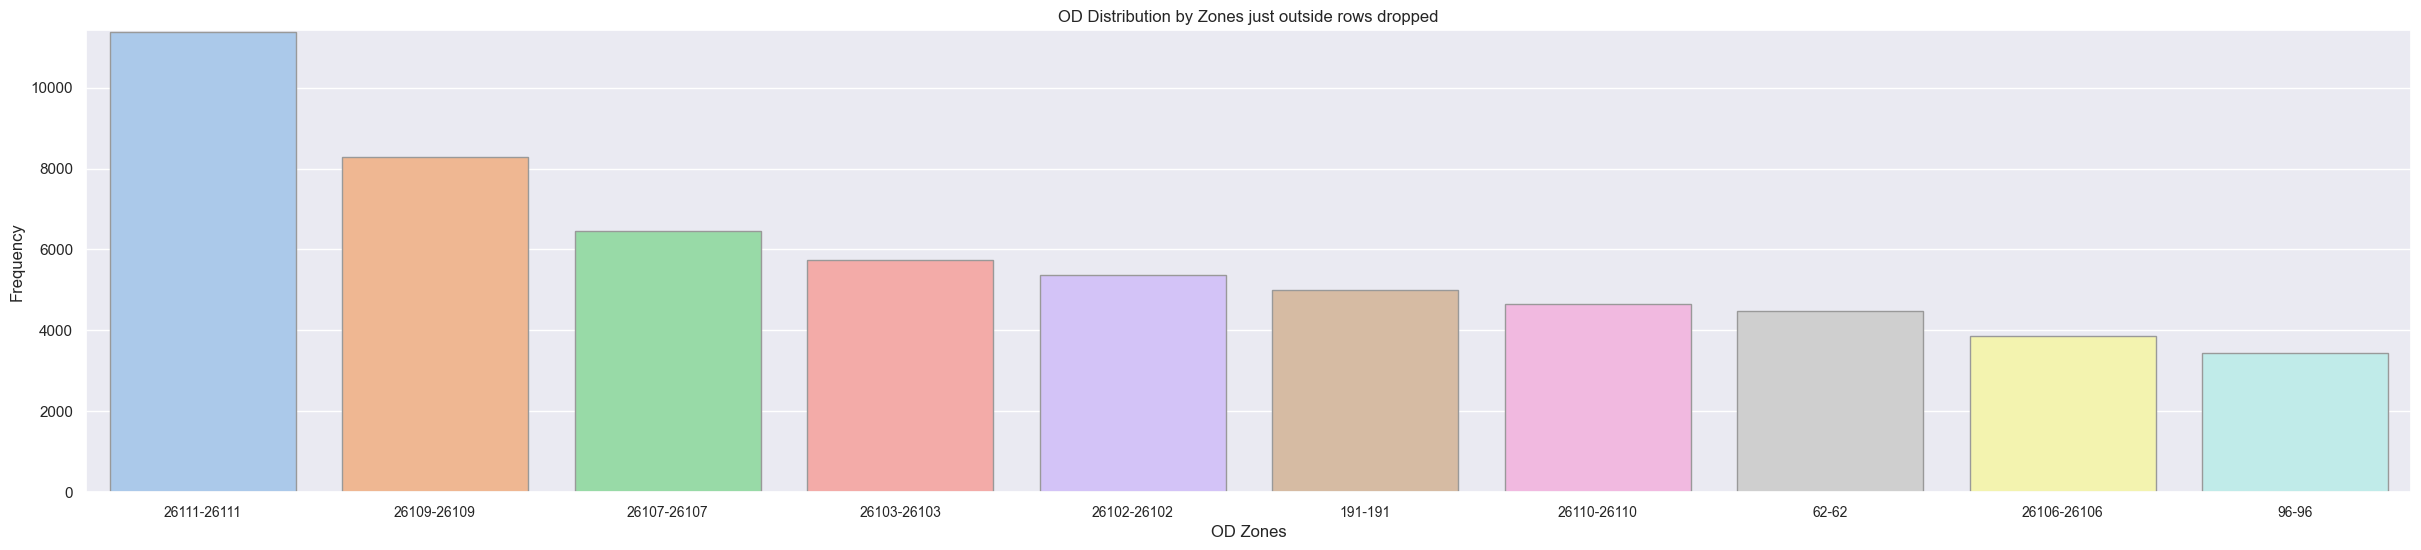

In [60]:
# Plot OD Distribution by zones of the trips_df_without_outside dataframe
# set sns style
sns.set(style="darkgrid")
plt.figure(figsize=(30, 6))

# Create a countplot for the 'OD_Zone' column 
value_counts = most_frequent_od_trips['OD_Zone'].value_counts().sort_values(ascending=False)
sns.countplot(data=trips_df_outside_dropped, x="OD_Zone", order=value_counts.index, palette="pastel", edgecolor=".6")


# Add labels and a title to the plot
plt.xlabel("OD Zones")
plt.ylabel("Frequency")
plt.title("OD Distribution by Zones just outside rows dropped")

# Set the x-axis and y-axis 
max_frequency = most_frequent_od_trips['OD_Zone'].value_counts().iloc[0] + 50
plt.ylim(0, max_frequency) 
xticks_range = range(0, 10)
plt.xticks(xticks_range)
plt.yticks()
plt.xticks(fontsize=10)

# Show the plot
plt.show()

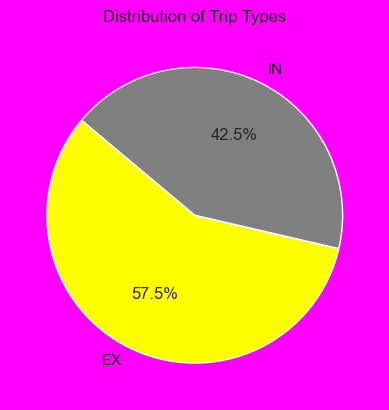

In [64]:
# Distribution of  EX and IN trips in trips_df_without_outside dataframe
trip_type_counts = trips_df_outside_dropped['trip_type'].value_counts()
# Create a figure and axes
fig, ax = plt.subplots()

# Set the colors of pie chart
colors = ['yellow', 'gray']

# Set the background color of the plot
fig.set_facecolor('magenta') 

ax.pie(trip_type_counts, labels=trip_type_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Trip Types')

# Display the pie chart
plt.show()

### <font color="orange"> Task 05: OD Distribution by Zone Part 3 (With all the data)

In [66]:
trips_df.head()

,id,plan_id,origin,destination,x_o,y_o,x_d,y_d,trip_start_time,trip_end_time
0,1.0,1.0,home,outside,2.679482e+06,1.237545e+06,2.687165e+06,1.240056e+06,07:50:56,NaN
1,9.0,1.0,outside,outside,2.687165e+06,1.240056e+06,2.688163e+06,1.240087e+06,08:44:00,NaN
2,10.0,1.0,outside,home,2.688163e+06,1.240087e+06,2.679482e+06,1.237545e+06,08:59:00,08:35:56
3,17.0,1.0,home,leisure,2.679482e+06,1.237545e+06,2.680684e+06,1.236911e+06,11:05:56,11:15:56
4,18.0,1.0,leisure,other,2.680684e+06,1.236911e+06,2.680896e+06,1.238970e+06,11:35:56,11:40:56


In [67]:
# Apply the function to your DataFrame and create separate lists
origin_zones_list, destination_zones_list = zip(*trips_df.apply(find_zone, axis=1))

In [68]:
# Create origin zone column
trips_df['origin_zone'] = origin_zones_list

# Create destination zone column
trips_df['destination_zone'] = destination_zones_list

In [69]:
trips_df['trip_type'] = trips_df.apply(get_trip_type, axis=1)

In [70]:
trips_df['OD_Zone'] = trips_df['origin_zone'] + '-' + trips_df['destination_zone']

In [71]:
# Select first 10 most frequent OD_Zone trips
temp_od = trips_df['OD_Zone'].value_counts().index
od_trips_to_drop = temp_od[10:]
most_frequent_od_trips = trips_df[~trips_df['OD_Zone'].isin(od_trips_to_drop)]

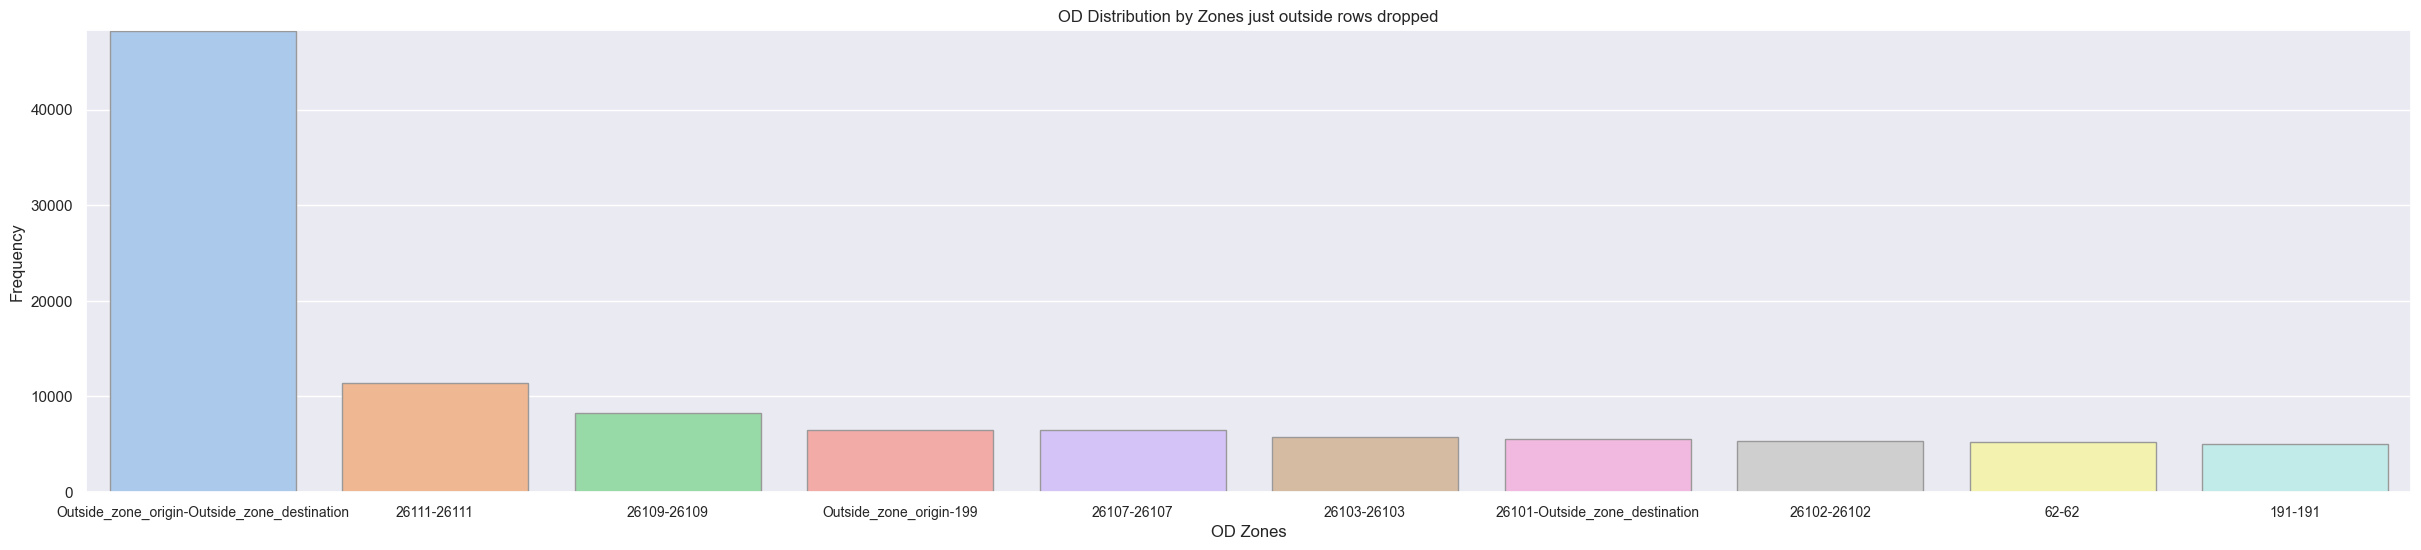

In [72]:
# Plot OD Distribution by zones of the trips_df_without_outside dataframe
# set sns style
sns.set(style="darkgrid")
plt.figure(figsize=(30, 6))

# Create a countplot for the 'OD_Zone' column 
value_counts = most_frequent_od_trips['OD_Zone'].value_counts().sort_values(ascending=False)
sns.countplot(data=trips_df, x="OD_Zone", order=value_counts.index, palette="pastel", edgecolor=".6")


# Add labels and a title to the plot
plt.xlabel("OD Zones")
plt.ylabel("Frequency")
plt.title("OD Distribution by Zones just outside rows dropped")

# Set the x-axis and y-axis 
max_frequency = most_frequent_od_trips['OD_Zone'].value_counts().iloc[0] + 50
plt.ylim(0, max_frequency) 
xticks_range = range(0, 10)
plt.xticks(xticks_range)
plt.yticks()
plt.xticks(fontsize=10)

# Show the plot
plt.show()

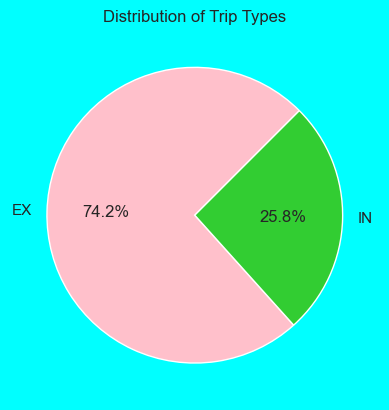

In [77]:
# Distribution of  EX and IN trips in trips_df_without_outside dataframe
trip_type_counts = trips_df['trip_type'].value_counts()
# Create a figure and axes
fig, ax = plt.subplots()

# Set the colors of pie chart
colors = ['pink', 'limegreen']

# Set the background color of the plot
fig.set_facecolor('cyan') 

ax.pie(trip_type_counts, labels=trip_type_counts.index, colors=colors, autopct='%1.1f%%', startangle=45)
plt.title('Distribution of Trip Types')

# Display the pie chart
plt.show()

## <font color="orange"> Task 06: Time Distribution of Activity or Trip

In [27]:
final_df = trips_df[['id', 'plan_id', 'trip_start_time', 'trip_end_time']]

In [29]:
final_df.head()

,id,plan_id,trip_start_time,trip_end_time
0,1.0,1.0,07:50:56,NaN
1,9.0,1.0,08:44:00,NaN
2,10.0,1.0,08:59:00,08:35:56
3,17.0,1.0,11:05:56,11:15:56
4,18.0,1.0,11:35:56,11:40:56


In [37]:
final_df = final_df.dropna(subset=['trip_start_time', 'trip_end_time'])

In [40]:
# Convert the 'trip_start_time' and 'trip_end_time' columns to datetime objects
final_df['trip_start_time'] = pd.to_datetime(final_df['trip_start_time'], format='%H:%M:%S')
final_df['trip_end_time'] = pd.to_datetime(final_df['trip_end_time'], format='%H:%M:%S')

# Calculate the duration as a timedelta
final_df['duration'] = final_df['trip_end_time'] - final_df['trip_start_time']

# Convert the duration timedelta to string (HH:MM:SS format)
final_df['duration'] = final_df['duration'].dt.strftime('%H:%M:%S')

ValueError: time data '24:05:56' does not match format '%H:%M:%S' (match)

In [41]:
final_df[final_df['trip_end_time'] == '24:05:56']

,id,plan_id,trip_start_time,trip_end_time


In [42]:
final_df[final_df['trip_start_time'] == '24:05:56']

,id,plan_id,trip_start_time,trip_end_time
13,27.0,1.0,24:05:56,24:15:56
120312,239449.0,30250.0,24:05:56,24:20:56
